<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Library-Imports" data-toc-modified-id="Library-Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Library Imports</a></span></li><li><span><a href="#Data-Loading" data-toc-modified-id="Data-Loading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Loading</a></span></li><li><span><a href="#Data-Wrangling" data-toc-modified-id="Data-Wrangling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Wrangling</a></span><ul class="toc-item"><li><span><a href="#Data-Filtering" data-toc-modified-id="Data-Filtering-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data Filtering</a></span></li><li><span><a href="#Aggregations-per-client-on-history-data" data-toc-modified-id="Aggregations-per-client-on-history-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Aggregations per client on history data</a></span></li></ul></li><li><span><a href="#Clients-Clustering" data-toc-modified-id="Clients-Clustering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clients Clustering</a></span><ul class="toc-item"><li><span><a href="#Columns-Selection-for-Clustering" data-toc-modified-id="Columns-Selection-for-Clustering-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Columns Selection for Clustering</a></span></li><li><span><a href="#Imputation-of-null-values" data-toc-modified-id="Imputation-of-null-values-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Imputation of null values</a></span></li><li><span><a href="#Data-Scaling" data-toc-modified-id="Data-Scaling-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Data Scaling</a></span></li><li><span><a href="#Elbow-Method-for-selecting-the-number-of-clusters" data-toc-modified-id="Elbow-Method-for-selecting-the-number-of-clusters-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Elbow Method for selecting the number of clusters</a></span></li><li><span><a href="#Selecting-the-number-of-clusters-using-Silhouette-Analysis" data-toc-modified-id="Selecting-the-number-of-clusters-using-Silhouette-Analysis-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Selecting the number of clusters using Silhouette Analysis</a></span></li><li><span><a href="#KMeans-Model-with-5-clusters" data-toc-modified-id="KMeans-Model-with-5-clusters-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>KMeans Model with 5 clusters</a></span><ul class="toc-item"><li><span><a href="#Clusters-Centroids-of-the-model" data-toc-modified-id="Clusters-Centroids-of-the-model-4.6.1"><span class="toc-item-num">4.6.1&nbsp;&nbsp;</span>Clusters Centroids of the model</a></span></li><li><span><a href="#Principal-Component-Analysis-for-plotting-high-dimensional-data" data-toc-modified-id="Principal-Component-Analysis-for-plotting-high-dimensional-data-4.6.2"><span class="toc-item-num">4.6.2&nbsp;&nbsp;</span>Principal Component Analysis for plotting high dimensional data</a></span><ul class="toc-item"><li><span><a href="#2D-plot-using-two-principal-components" data-toc-modified-id="2D-plot-using-two-principal-components-4.6.2.1"><span class="toc-item-num">4.6.2.1&nbsp;&nbsp;</span>2D plot using two principal components</a></span></li><li><span><a href="#3D-plot-using-three-principal-components" data-toc-modified-id="3D-plot-using-three-principal-components-4.6.2.2"><span class="toc-item-num">4.6.2.2&nbsp;&nbsp;</span>3D plot using three principal components</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Library Imports

[(Back to top)](#Table-of-Contents)

In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import warnings
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import matplotlib.cm as cm
import dask.dataframe as dd
import os
import itertools
import matplotlib.ticker as ticker
from functools import reduce
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
alt.renderers.enable('default')
sns.set_theme(style="darkgrid")
warnings.filterwarnings('ignore')
sns.set_palette(sns.color_palette("Set3"))

# Data Loading

[(Back to top)](#Table-of-Contents)

In [2]:
uid = 'msno'

In [3]:
# This can be changed to the directory where the datasets are stored
data_dir = './data'

# Training data for january, contains two columns : user id and binary churn target variable
train = pd.read_csv(os.path.join(data_dir, 'train.csv'), dtype={'is_churn': str})

train.head()

,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


In [4]:
user_logs = dd.read_csv(os.path.join(data_dir, 'user_logs_cleaned.csv'), header=None,
                        names=['msno','date','num_25','num_50','num_75','num_985','num_100','num_unq','total_secs'])
transactions = pd.read_csv(os.path.join(data_dir, 'transactions_cleaned.csv'))
members = pd.read_csv(os.path.join(data_dir, 'members_v3.csv'))

# Data Wrangling

## Data Filtering

[(Back to top)](#Table-of-Contents)

We will only use the history of the clients **prior to 31/01/2017** since we will only use this history for the training part of future models.

In [5]:
date_pred = 20170131

In [12]:
user_logs = user_logs.loc[user_logs.date <= date_pred]

In [6]:
transactions = transactions.loc[transactions.transaction_date <= date_pred]

In [7]:
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'], format='%Y%m%d')

## Aggregations per client on history data

[(Back to top)](#Table-of-Contents)

In [8]:
# Computing the number of cancels each client has done over the history
nbr_cancels = transactions.groupby(uid).agg(nbr_cancels=("is_cancel", "sum")).reset_index()

In [9]:
# Only taking the subscription transactions to compute the aggregations since the cancel will only bias them
filtered_trx = transactions.loc[transactions.is_cancel == 0]

In [10]:
# Important descriptive features for the clients behaviors'
aggs_trx = filtered_trx.groupby(uid).agg(total_days_subscribed=("payment_plan_days", "sum"), 
                                         total_amount_paid=("actual_amount_paid", "sum"),
                                         average_days_subscribed=("payment_plan_days", "mean"),
                                         average_amount_paid=("actual_amount_paid", "mean"),
                                         percentage_auto_renew=("is_auto_renew", "mean")
                                        ).reset_index()

In [32]:
aggs_trx.head(3)

,msno,total_days_subscribed,total_amount_paid,average_days_subscribed,average_amount_paid,percentage_auto_renew
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,7,0,7.0,0.0,0.0
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,805,3387,402.5,1693.5,0.0
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,90,297,30.0,99.0,1.0


In [13]:
# Using Dask API to generate basic features from the user logs dataset
aggs_user_logs = user_logs.groupby(uid).agg({'total_secs': ['mean', 'sum'],
                                             'num_unq': ['mean', 'sum']}).compute()

In [14]:
aggs_user_logs = aggs_user_logs.reset_index()
aggs_user_logs.columns = ['_'.join(x) for x in aggs_user_logs.columns.ravel()]
aggs_user_logs.rename(columns={'msno_': 'msno'}, inplace=True)

aggs_user_logs_filtered = aggs_user_logs[aggs_user_logs[uid].isin(train[uid])]

aggs_user_logs_filtered.reset_index(inplace=True)

In [15]:
# Saving the aggregations data for future use
aggs_trx.to_csv('./data/agg_transactions.csv', index=False)

aggs_user_logs_filtered.to_csv('./data/agg_user_logs.csv', index=False)

In [5]:
aggs_trx = pd.read_csv('./data/agg_transactions.csv')
aggs_user_logs = pd.read_csv('./data/agg_user_logs.csv')

In [6]:
# Merging the aggregations using a left merge on the uid column
merged_aggs = reduce(lambda x,y: x.merge(y, how="left", on=uid),
                     [train[[uid]], aggs_user_logs, aggs_trx, members[[uid, 'bd']]])

# Clients Clustering

## Columns Selection for Clustering

[(Back to top)](#Table-of-Contents)

In [7]:
# These are the columns that best describe a client's historical behavior that will later be used as features
clustering_cols = ['bd', 'total_amount_paid', 'total_days_subscribed',
                   'num_unq_mean', 'total_secs_mean', 'total_secs_sum']

## Imputation of null values

[(Back to top)](#Table-of-Contents)

In [8]:
# Using the median value of the age as an imputation value for the column
merged_aggs['bd'].fillna(merged_aggs['bd'].mean(), inplace=True)

In [9]:
merged_aggs.isnull().agg(['mean','sum'])

,msno,index,total_secs_mean,total_secs_sum,num_unq_mean,num_unq_sum,total_days_subscribed,total_amount_paid,average_days_subscribed,average_amount_paid,percentage_auto_renew,bd
mean,0.0,0.128103,0.128103,0.128103,0.128103,0.128103,0.002114,0.002114,0.002114,0.002114,0.002114,0.0
sum,0.0,127197.000000,127197.000000,127197.000000,127197.000000,127197.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,0.0


In [10]:
# Filling the rest of the null values with 0, since the percentage of missing values is relatively small 
merged_aggs.fillna(0, inplace=True)

In [11]:
# Generating the master table by only selecting the necessary columns
dataset = merged_aggs[clustering_cols]

## Data Scaling

[(Back to top)](#Table-of-Contents)

In [12]:
X = dataset.values

In [13]:
X_std = preprocessing.scale(X)

## Elbow Method for selecting the number of clusters

[(Back to top)](#Table-of-Contents)

In [14]:
# calculate inertia for a range of number of cluster
# inertia = within cluster sum of squares (WCSS)
inertias = []
for i in range(1, 11):
    print("Fitting the KMeans algorithm with a number of clusters = {0}".format(i))
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_std)
    inertias.append(km.inertia_)


Fitting the KMeans algorithm with a number of clusters = 1
Fitting the KMeans algorithm with a number of clusters = 2
Fitting the KMeans algorithm with a number of clusters = 3
Fitting the KMeans algorithm with a number of clusters = 4
Fitting the KMeans algorithm with a number of clusters = 5
Fitting the KMeans algorithm with a number of clusters = 6
Fitting the KMeans algorithm with a number of clusters = 7
Fitting the KMeans algorithm with a number of clusters = 8
Fitting the KMeans algorithm with a number of clusters = 9
Fitting the KMeans algorithm with a number of clusters = 10


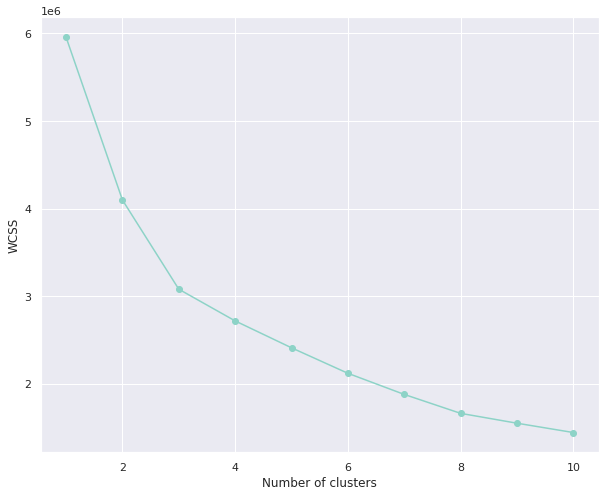

In [15]:
# plot WCSS vs number of clusters
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Selecting the number of clusters using Silhouette Analysis 

[(Back to top)](#Table-of-Contents)

Next, we will perform the **Silhouette Analysis** method to select the optimal value for the n clusters argument to provide for the KMeans algorithm. More info about the method can be found in Scikit-Learn's <a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html">documentation</a>.

Silhouette Analysis is used to study how different or far away are each point of one cluster to the other neighboring clusters. ***A silhouette score of +1 for one point means that that point is actually correctly assigned** to its appropriate cluster and is far from the other clusters. **A value of 0 means that the point is on the border of the decision boundary of the clustering**, and **a negative value means that the point has been assigned to the incorrect cluster**.

We can get a good visual representation of how the clusters and assess how the clustering actually was visually.

I have modified the <a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html">code</a> provided by Scikit-Learn to handle multi dimensional data by **using two principal components for the plots** and **only taking a sample** (subset of the data) for fitting the kmeans model.

In [30]:
pca_df = dataset[['pca-one', 'pca-two']].values

For n_clusters = 4 The average silhouette_score is : 0.3124174783049068
For n_clusters = 5 The average silhouette_score is : 0.3131228506067964
For n_clusters = 6 The average silhouette_score is : 0.2877614975963808
For n_clusters = 9 The average silhouette_score is : 0.29772440263732397
For n_clusters = 12 The average silhouette_score is : 0.3050783054662256


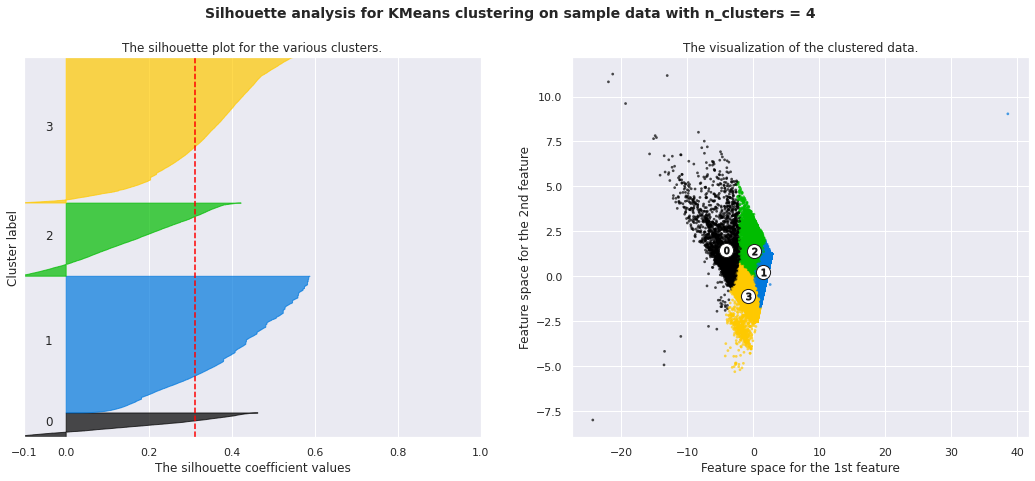

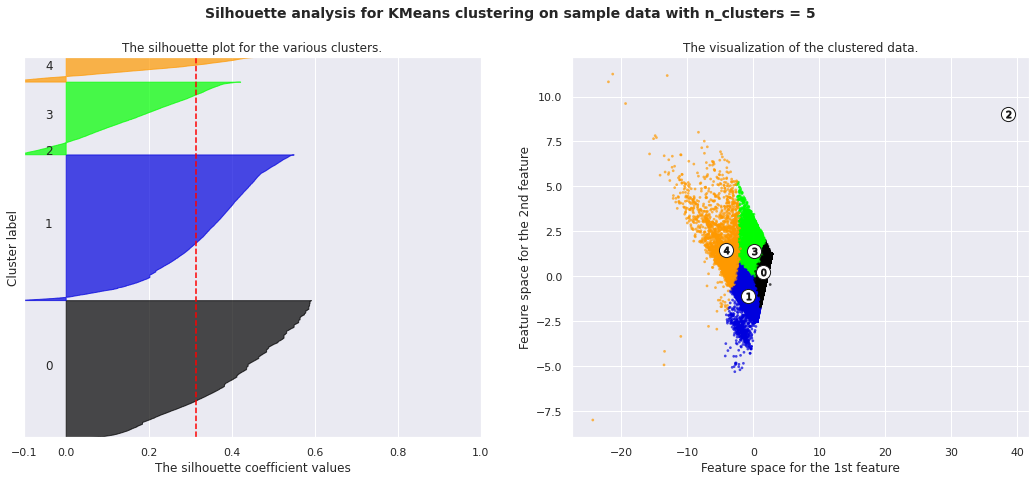

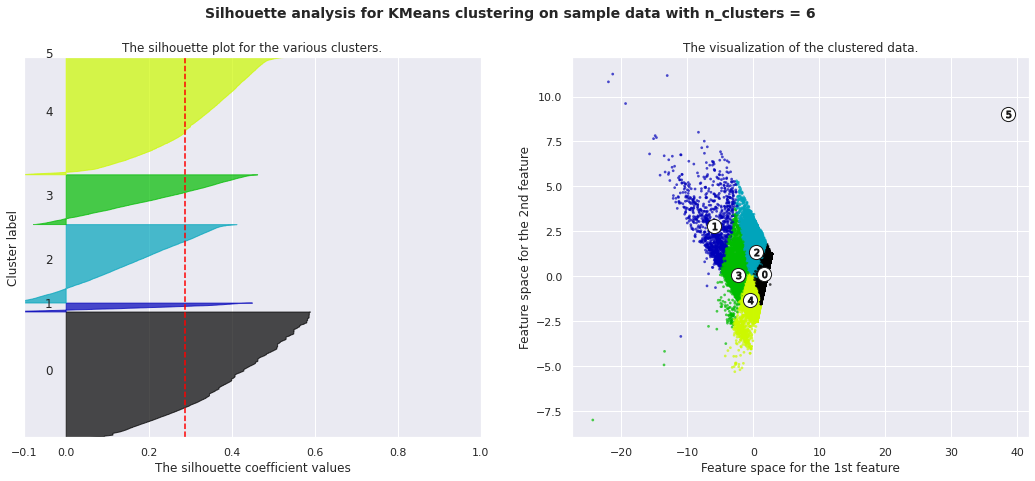

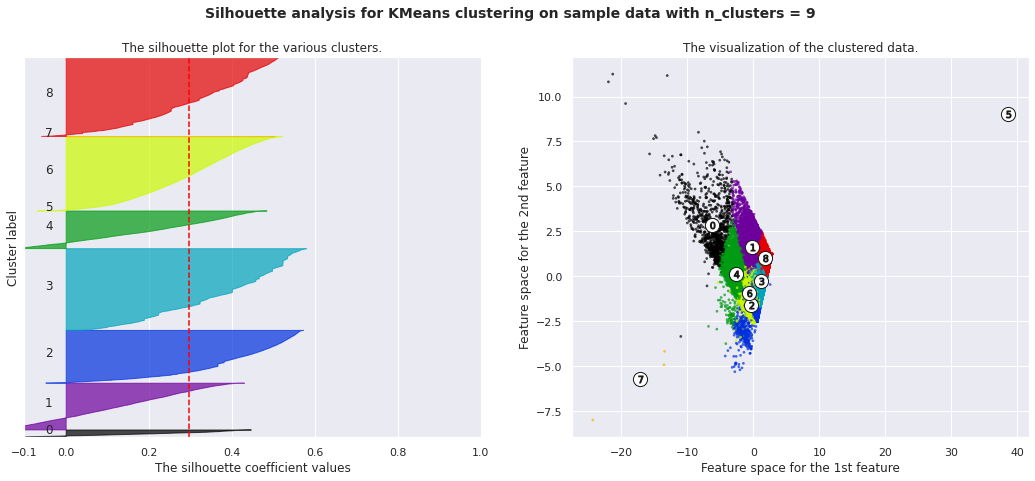

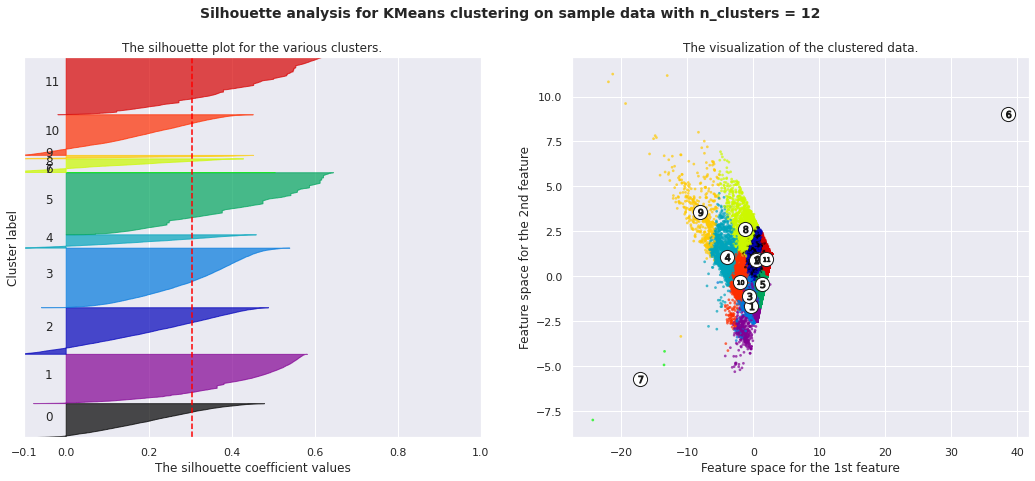

In [40]:
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
rnd_idx = np.random.choice(X_std.shape[0], int(0.05 * X_std.shape[0]), replace=False)
sample = X_std[rnd_idx, :]
X = sample

range_n_clusters = [4, 5, 6, 9, 12]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    X_pca = pca_df[rnd_idx, :]
    ax2.scatter(
        X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = pca.transform(clusterer.cluster_centers_)[:, :2]
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st principal component")
    ax2.set_ylabel("Feature space for the 2nd principal component")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on the sample with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Judging from the results obtained, from evaluating both of the average silhouette score and from the assessment from the plots visually, we can see that the correct number of clusters to select for the KMeans algorithm is **n=5 clusters**. 4 clusters is also a good candidate to select for the KMeans algorithm, but we will use n=5 clusters.

## KMeans Model with 5 clusters

[(Back to top)](#Table-of-Contents)

In [16]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
y_kmeans = kmeans.fit_predict(X_std)

# Beginning of  the cluster numbering with 1 instead of 0
y_kmeans = y_kmeans + 1

# Adding cluster to the dataset
dataset['cluster'] = y_kmeans

# Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(dataset.groupby('cluster').mean(),1))


### Clusters Centroids of the model

In [17]:
clusters_size = dataset['cluster'].value_counts(normalize=True).reset_index(
    name="cluster_size_percentage").rename(columns={'index': 'cluster'})

In [18]:
clusters_centroids = clusters_size.merge(kmeans_mean_cluster.reset_index().rename(columns={'bd': 'age'}),
                                         how="left", on="cluster").sort_values('cluster')

In [19]:
clusters_centroids

,cluster,cluster_size_percentage,age,total_amount_paid,total_days_subscribed,num_unq_mean,total_secs_mean,total_secs_sum
1,1,0.304737,17.8,3258.7,647.8,17.4,4313.1,1580614.1
2,2,0.176816,10.9,1003.5,240.7,33.6,8554.9,1324674.7
3,3,0.134799,23.0,3103.6,611.7,39.1,10768.0,5599985.9
0,4,0.358847,6.8,1082.6,302.1,9.4,2124.7,250393.5
4,5,0.024801,22.7,2767.5,548.2,81.9,26406.3,13524040.2


In [24]:
# Generating the average of the features for the whole clients, to get a good comparison with
# the centroids
dataset.drop('cluster', 1).agg(['mean']).rename(columns={'bd': 'age'})

,age,total_amount_paid,total_days_subscribed,num_unq_mean,total_secs_mean,total_secs_sum
mean,13.453973,2045.975758,444.410738,21.930879,5695.865027,1.896034e+06


**Insights generated from the centroids of the KMeans clustering :**

- Cluster number **5** contains the oldest clients of the database (despite not being old with an average age of **23** years old), these clients have the **most time spent listening** with both the total of seconds listens and the total number of unique songs listened. The **total amount paid for the cluster is very high** (3100 NTD) and close to the highest  among all clusters.
- Cluster number **4** contains the **highest percentage of the clients** (**35%**): they are **the youngest but they are also the ones that spend the least time on the streaming service and also spend the least amount of money**.
- Cluster number **1** contains a third of the clients database, they also have **the highest total amount paid (3258 NTD) and the most days subscribed**.


### Principal Component Analysis for plotting high dimensional data

[(Back to top)](#Table-of-Contents)

In [27]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_std)
dataset['pca-one'] = pca_result[:,0]
dataset['pca-two'] = pca_result[:,1] 
dataset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.50210825 0.28150467 0.14713495]


In [69]:
pca.explained_variance_ratio_.sum()

0.9307478756115494

We can see that by using the principal component analysis with 3 components, we are able to reduce the dimensionality while keeping most of the original dataset variance: **about 93% of the explained variance is kept after doing PCA** by using **3 components** and **about 78%** of the explained variance is kept by using **2 components**.

#### 2D plot using two principal components

[(Back to top)](#Table-of-Contents)

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

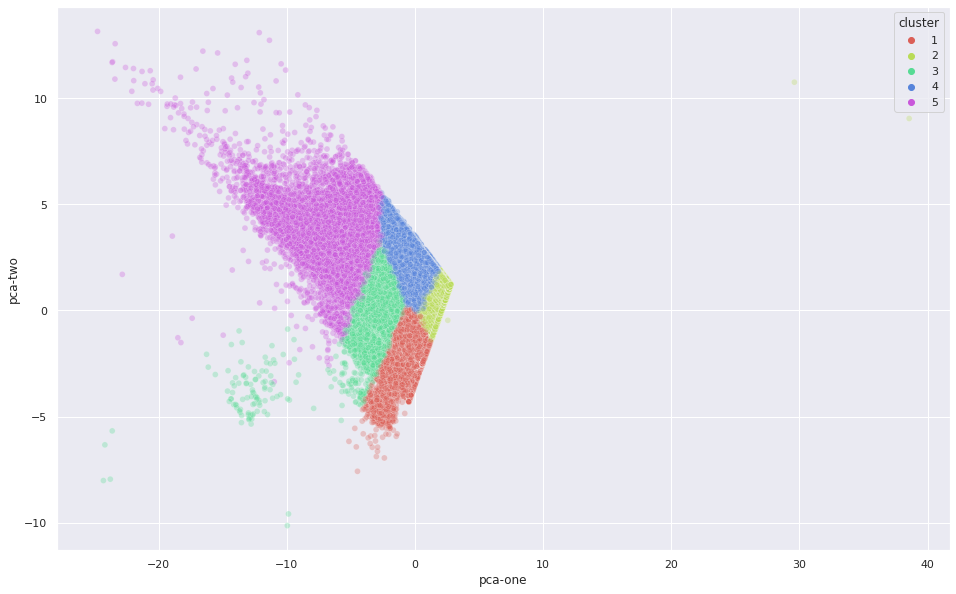

In [28]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="cluster",
    palette=sns.color_palette("hls", dataset['cluster'].nunique()),
    data=dataset,
    legend="full",
    alpha=0.3
)

#### 3D plot using three principal components

[(Back to top)](#Table-of-Contents)

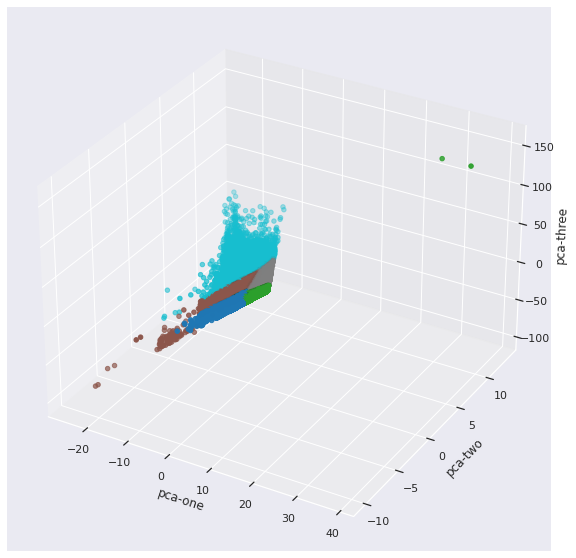

In [29]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=dataset["pca-one"], 
    ys=dataset["pca-two"], 
    zs=dataset["pca-three"], 
    c=dataset["cluster"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()